In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict
from konlpy.tag import Okt
from datetime import datetime
import os

In [6]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제21대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_21/팍스넷_21대_대선_테마주_크롤링_20250627.csv"
POS_PATH = "../03_모델링/sentiment_dictionary/final_positive_dict.csv"
NEG_PATH = "../03_모델링/sentiment_dictionary/final_negative_dict.csv"

FIXED_START = datetime(2025, 3, 28)
FIXED_END = datetime(2025, 6, 10)

In [7]:
# ───────────── 데이터 로딩 ─────────────
df = pd.read_csv(PAXNET_PATH)
df["날짜"] = pd.to_datetime(df["날짜"])

positive_df = pd.read_csv(POS_PATH)
negative_df = pd.read_csv(NEG_PATH)
sentiment_dict = {
    **dict(zip(positive_df["단어"], positive_df["최종점수"])),
    **dict(zip(negative_df["단어"], negative_df["최종점수"]))
}

okt = Okt()

In [8]:
# ───────────── 감성 점수 계산 함수 ─────────────
def compute_sentiment_by_date(df, stock_name, sentiment_dict, okt):
    score_by_date = defaultdict(float)
    for _, row in df[df["종목명"] == stock_name].iterrows():
        date = row["날짜"].date()
        text = f"{row['제목']} {row['내용']}"
        words = set(okt.morphs(text))
        score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
        score_by_date[date] += score
    return score_by_date

In [9]:
# ───────────── 종목별 감성 점수 및 주가 저장 ─────────────
all_stock_sentiment = {}
all_stock_prices = {}

for file_name in os.listdir(DATA_DIR):
    if not file_name.endswith(".csv"):
        continue

    file_path = os.path.join(DATA_DIR, file_name)
    price_df = pd.read_csv(file_path)
    price_df["Date"] = pd.to_datetime(price_df["Date"])
    price_df = price_df[(price_df["Date"] >= FIXED_START) & (price_df["Date"] <= FIXED_END)]

    if price_df.empty:
        continue

    stock_name = price_df["Name"].iloc[0]
    score_by_date = compute_sentiment_by_date(df, stock_name, sentiment_dict, okt)

    sentiment_df = pd.DataFrame({
        "날짜": pd.to_datetime(list(score_by_date.keys())),
        "감성점수": list(score_by_date.values())
    }).sort_values("날짜")

    all_stock_sentiment[stock_name] = sentiment_df
    all_stock_prices[stock_name] = price_df

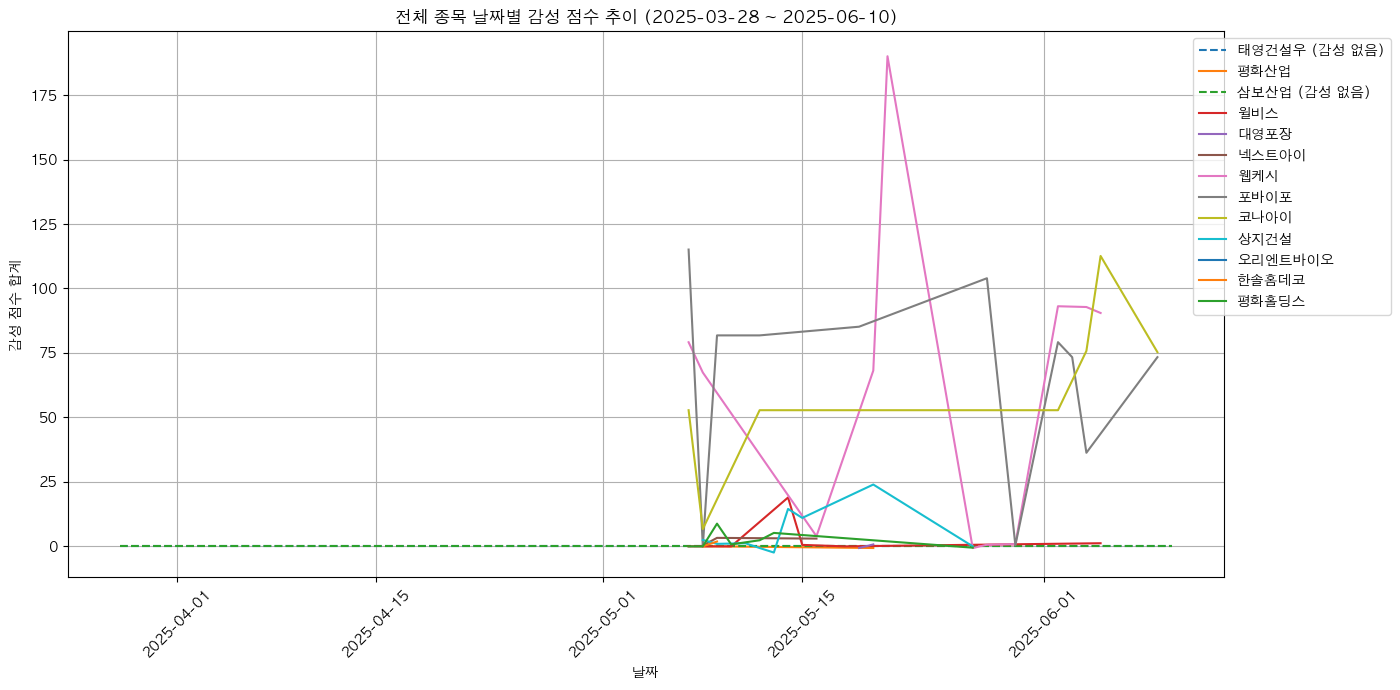

In [10]:
# ───────────── [1] 전체 종목 감성 점수 추이 ─────────────
plt.figure(figsize=(14, 7))

for stock, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    if filtered_sentiment.empty:
        # 날짜 축만 유지하고 y=0 값으로 대체
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', label=f"{stock} (감성 없음)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"], label=stock)

plt.title("전체 종목 날짜별 감성 점수 추이 (2025-03-28 ~ 2025-06-10)")
plt.xlabel("날짜")
plt.ylabel("감성 점수 합계")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

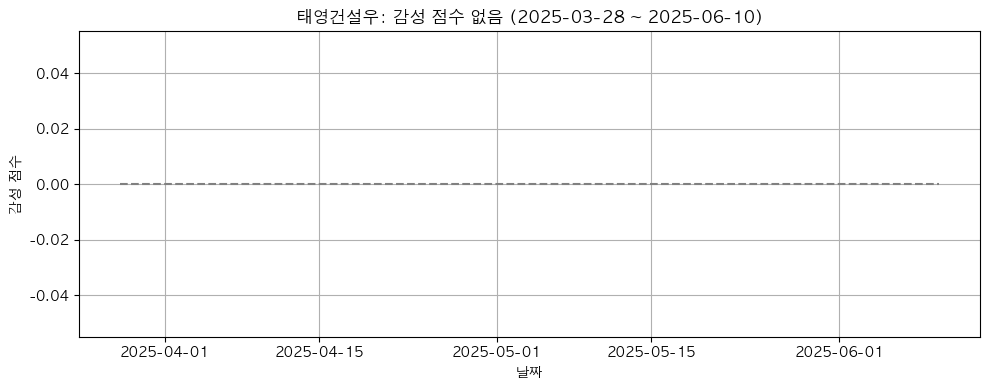

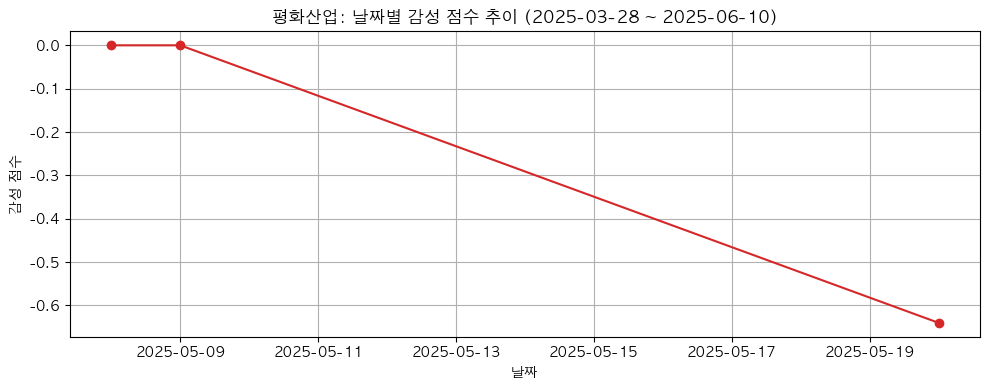

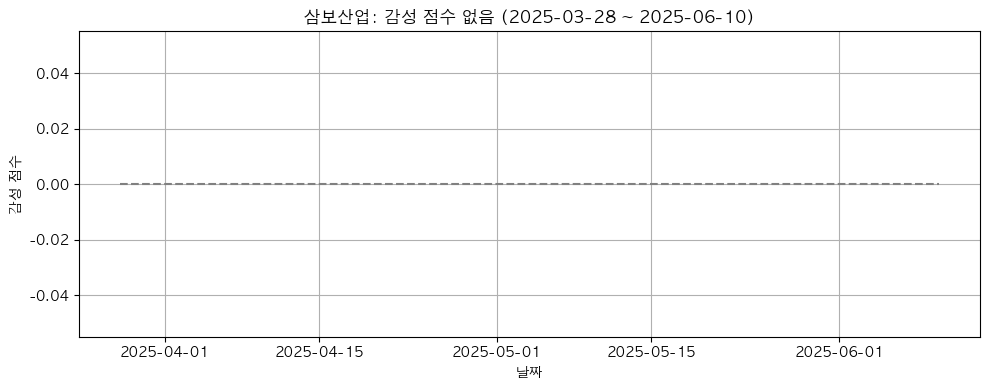

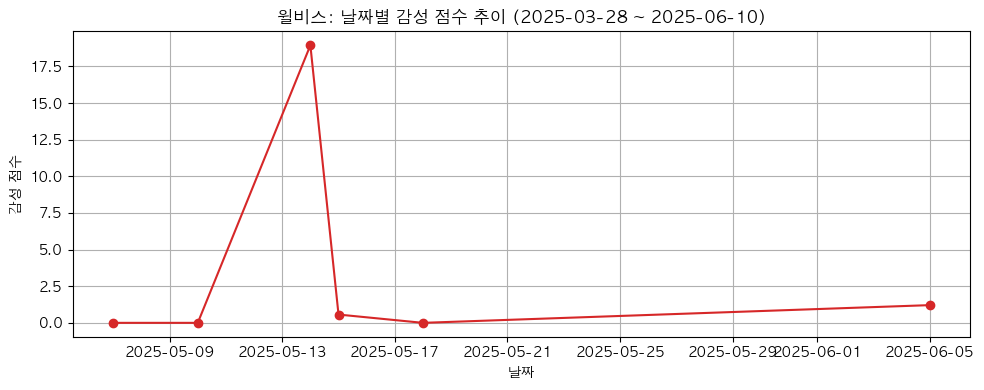

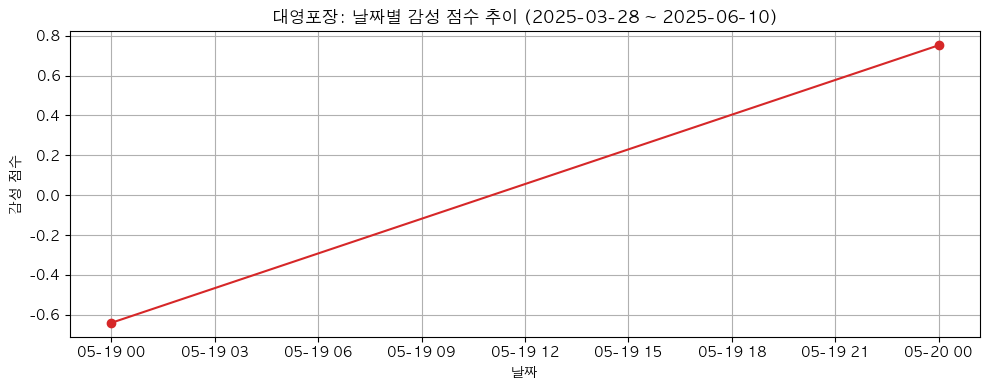

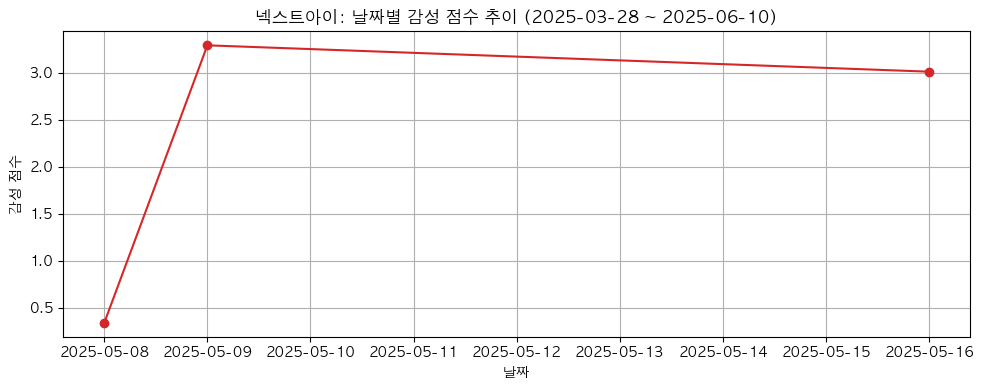

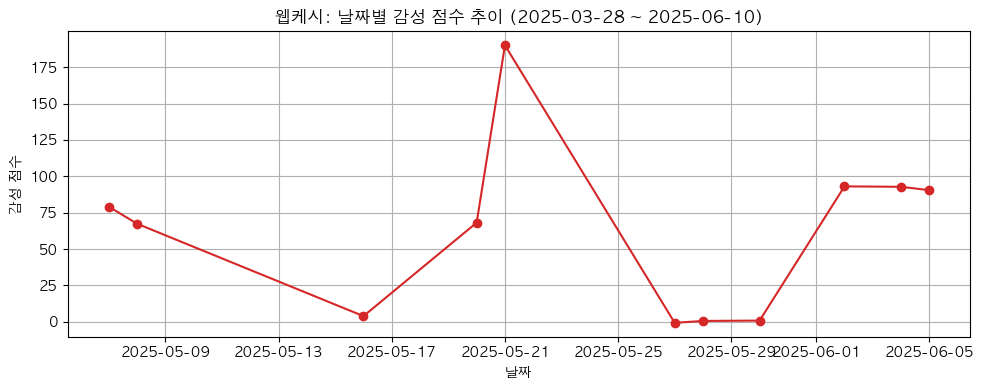

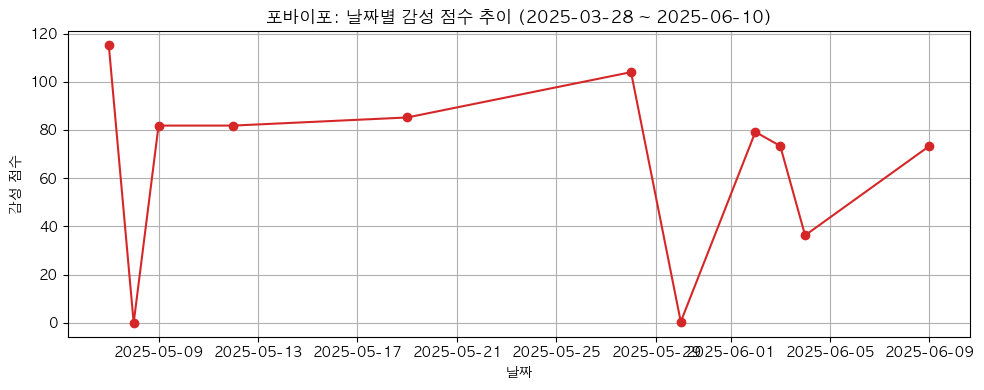

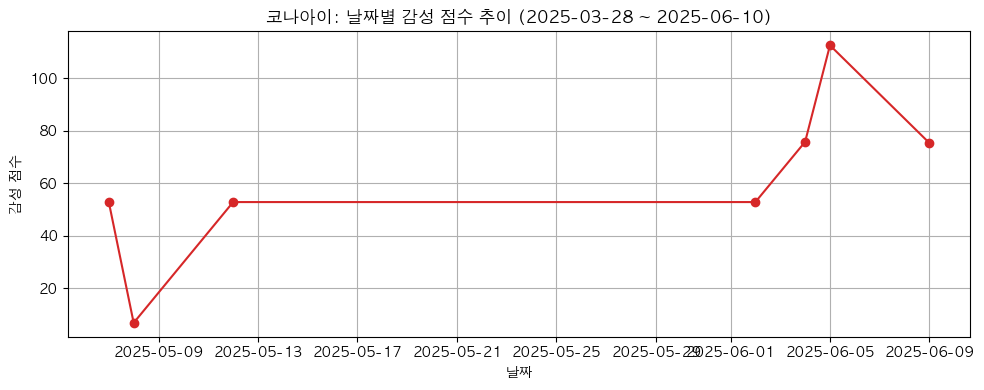

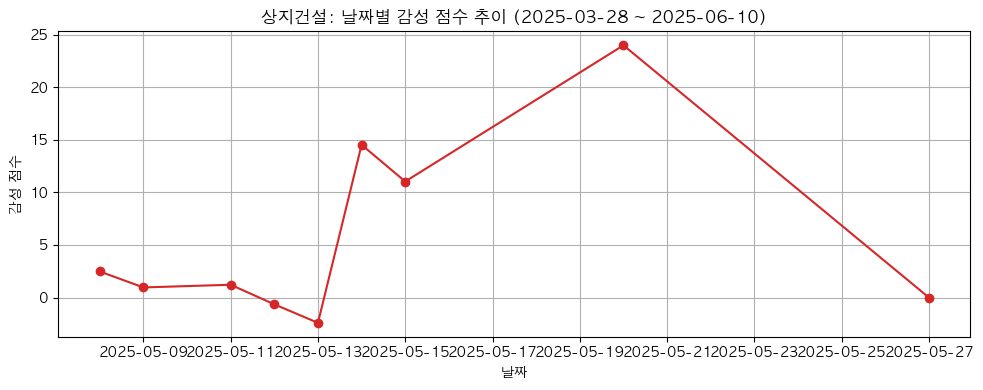

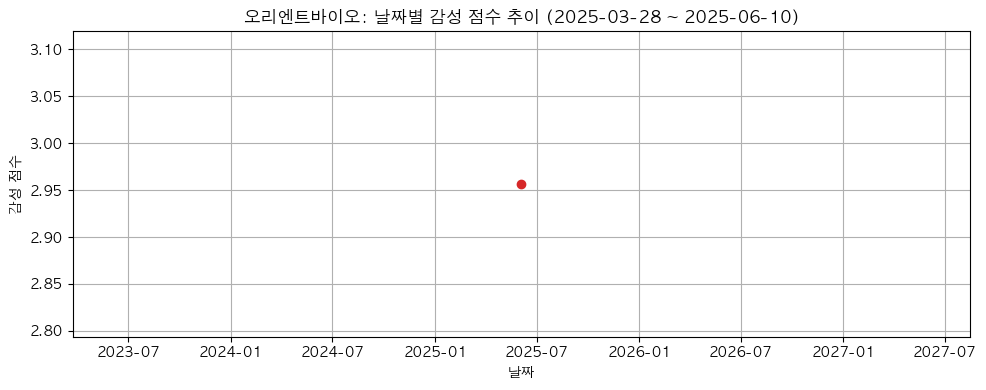

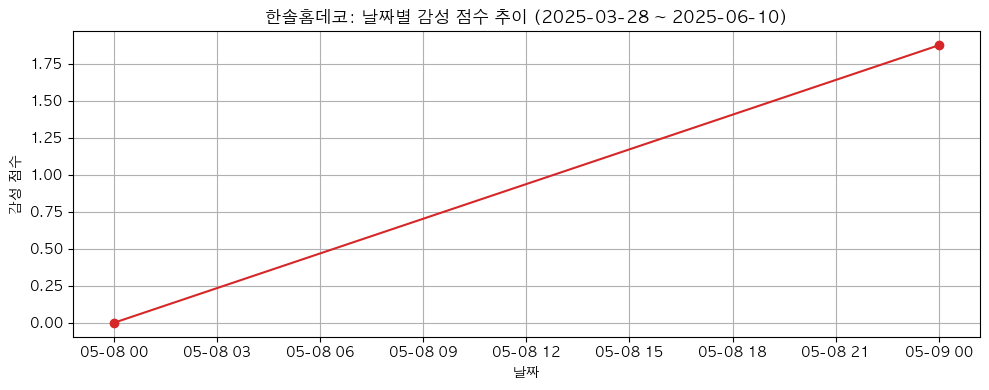

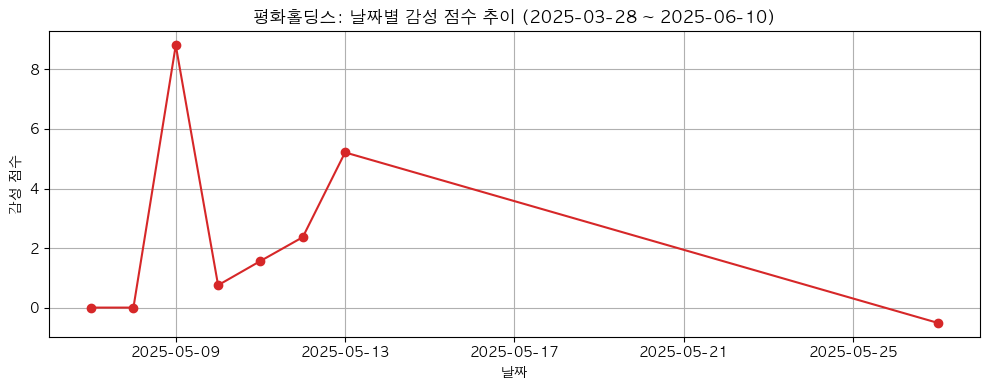

In [11]:
# ───────────── [2] 종목별 감성 점수만 시각화 ─────────────
for stock_name, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]

    plt.figure(figsize=(10, 4))
    if filtered_sentiment.empty:
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', color='gray')
        plt.title(f"{stock_name}: 감성 점수 없음 (2025-03-28 ~ 2025-06-10)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"],
                 marker='o', color='tab:red')
        plt.title(f"{stock_name}: 날짜별 감성 점수 추이 (2025-03-28 ~ 2025-06-10)")
    plt.xlabel("날짜")
    plt.ylabel("감성 점수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

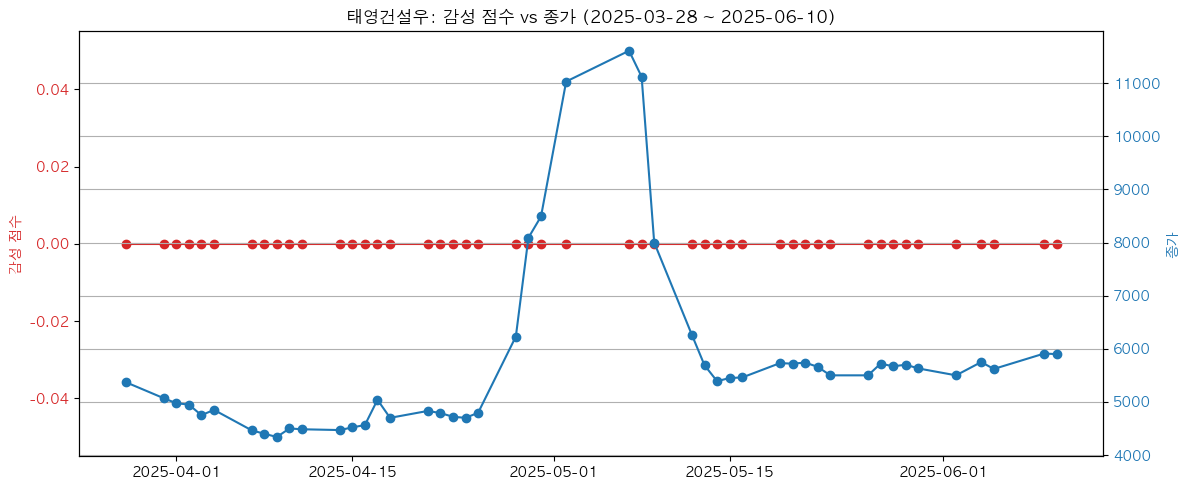

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.    0.   -0.64]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


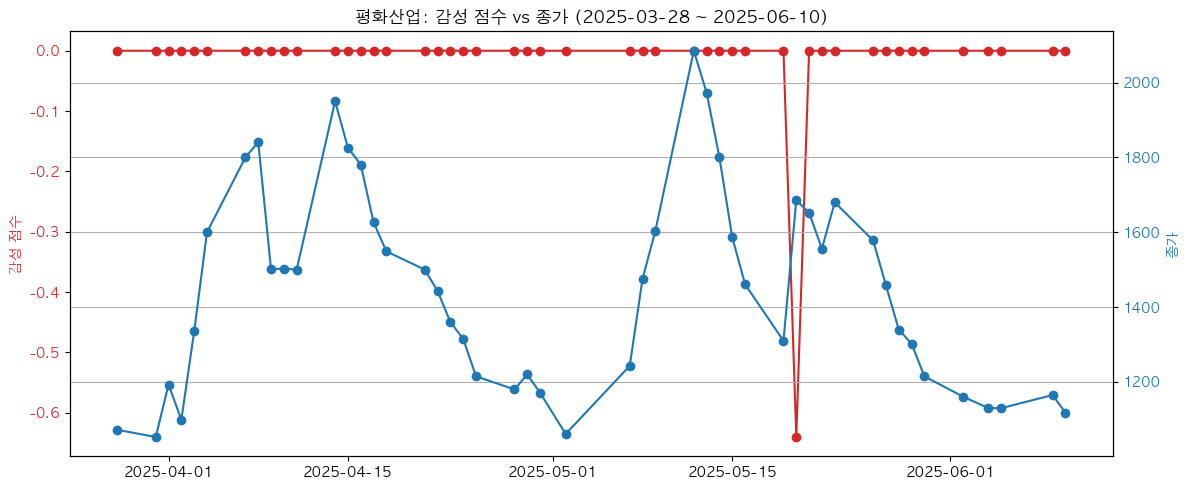

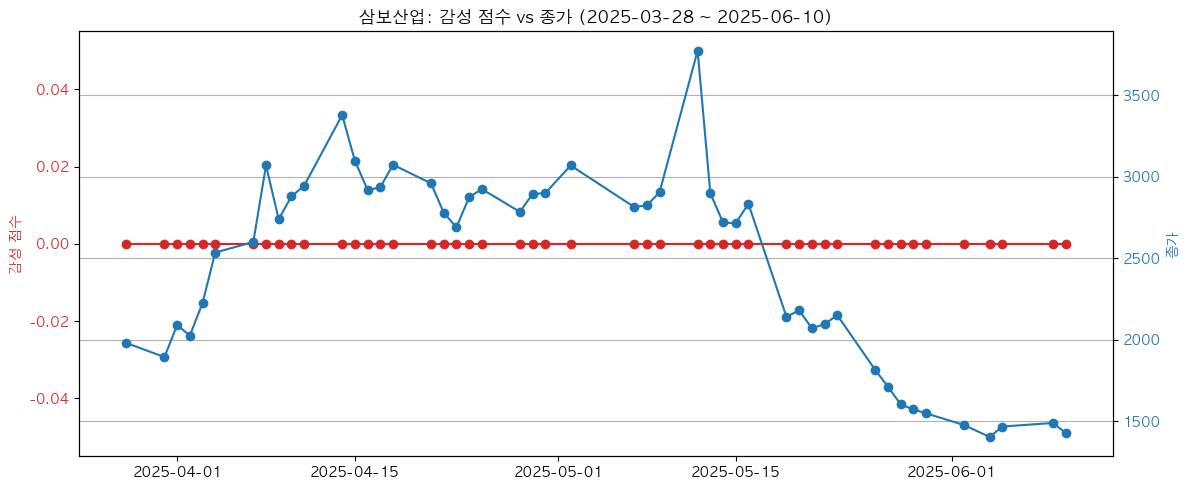

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.     18.9443  0.5662  1.2085]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


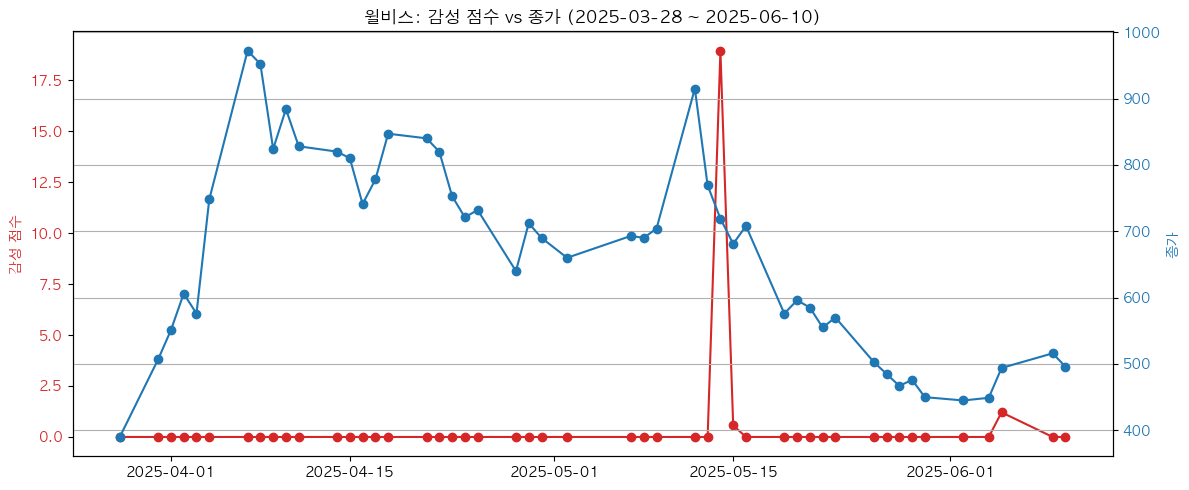

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.64   0.752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


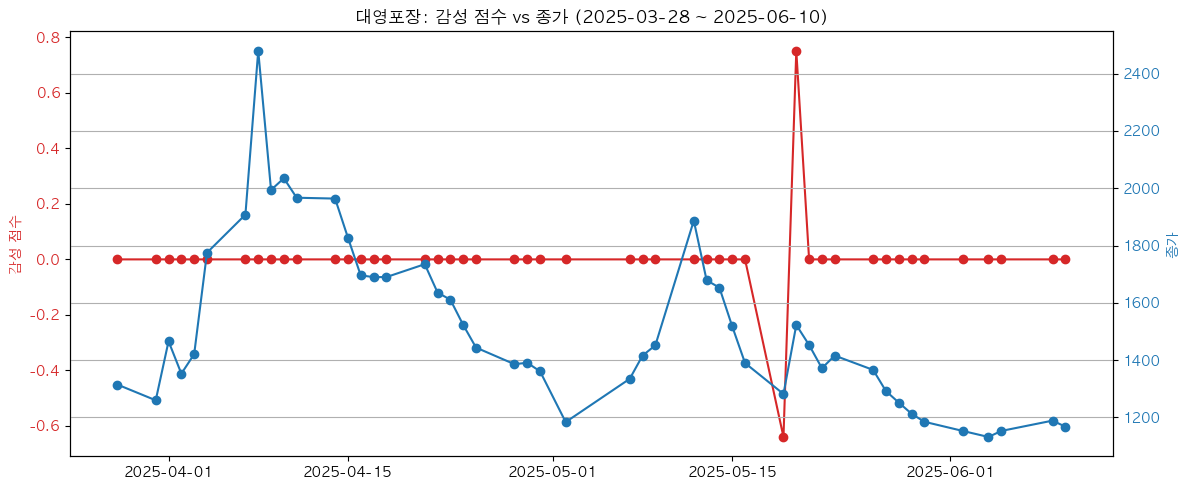

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.3398 3.291  3.0108]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


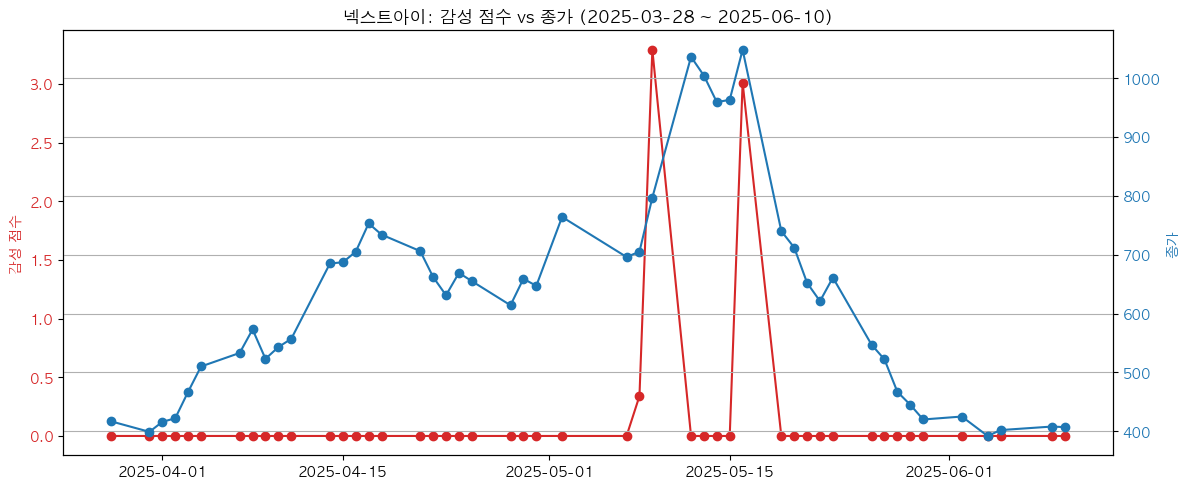

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 79.1563  67.4144   3.9432  68.1664 190.0557  -0.68     0.6369   0.864
  93.1087  92.8123  90.497 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


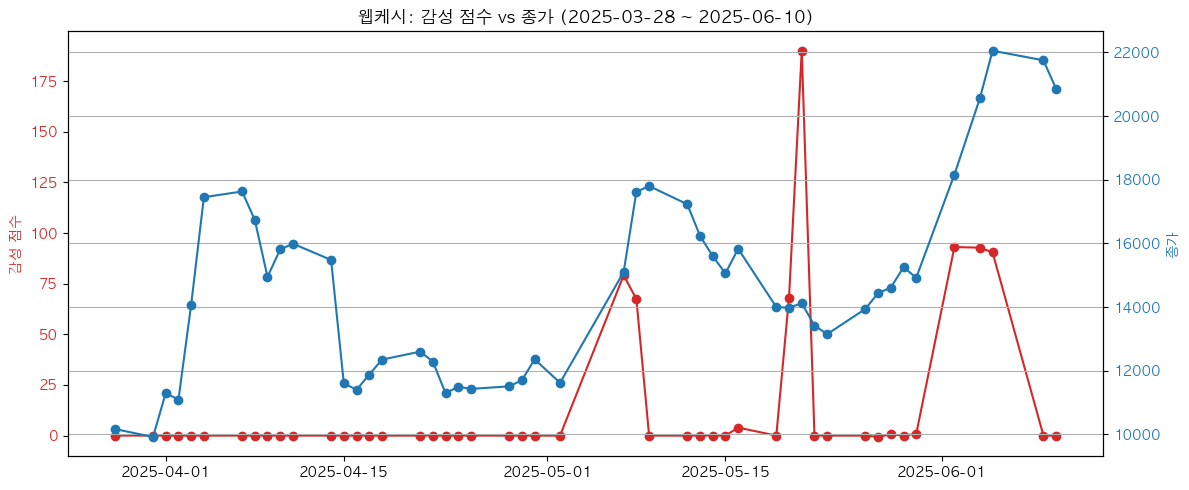

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[115.0947   0.      81.809   81.809   85.1767 103.97     0.4316  79.1802
  36.2854  73.3596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


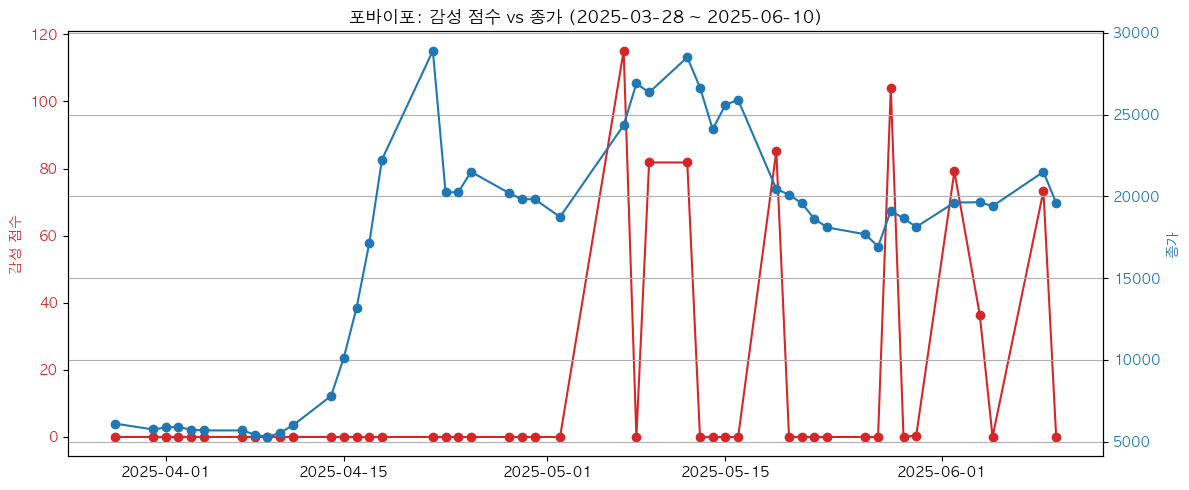

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 52.7987   6.7156  52.7987  52.7987  75.7755 112.6065  75.3078]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


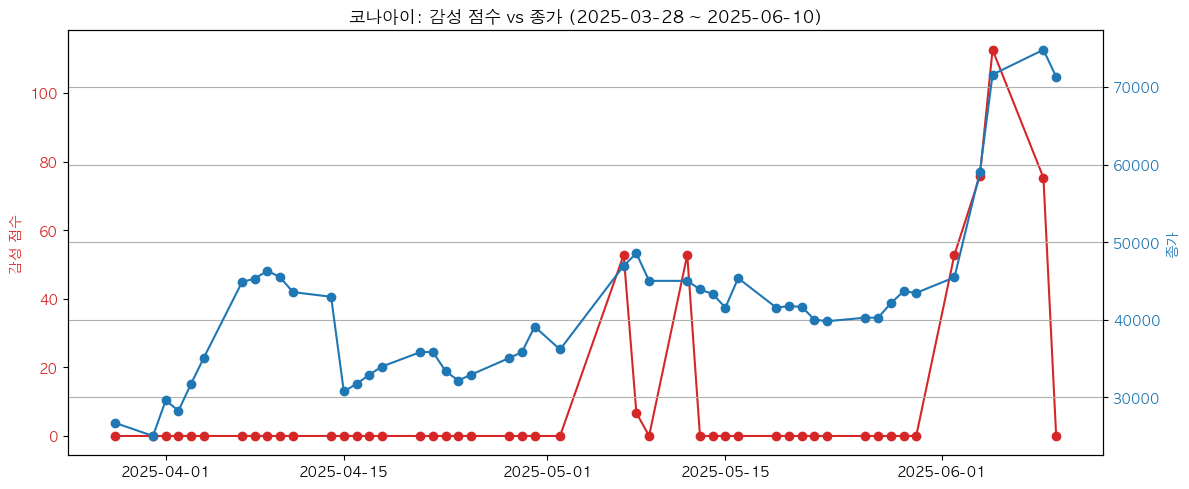

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.4834  0.9642 -2.4    14.5202 11.0308 23.9738  0.    ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


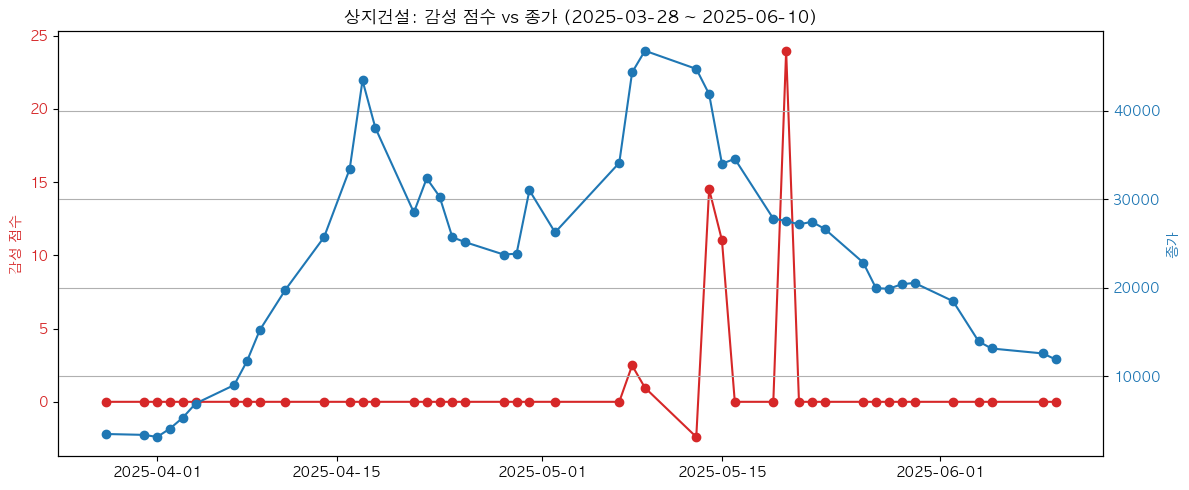

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.9564]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


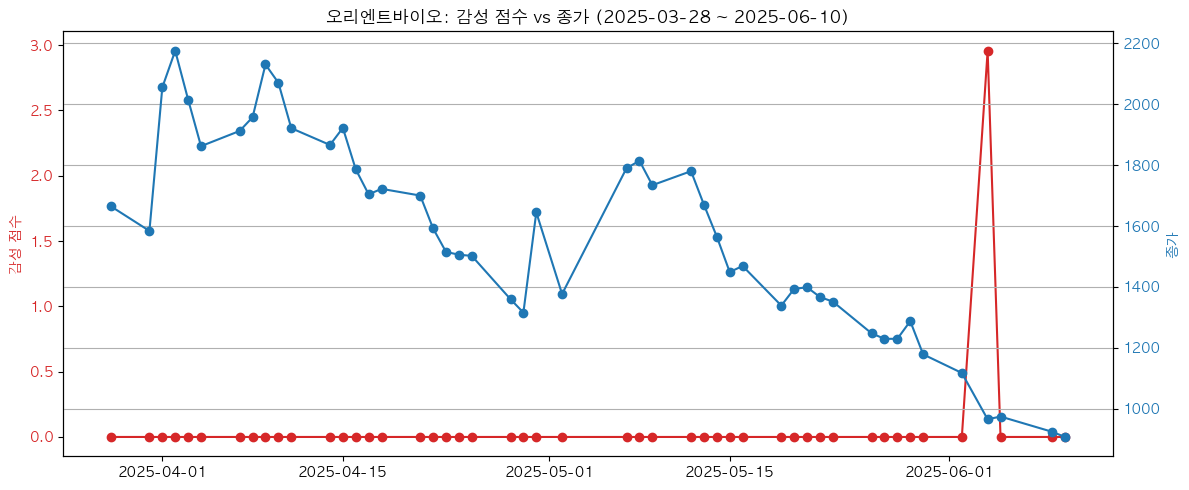

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.    1.873]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


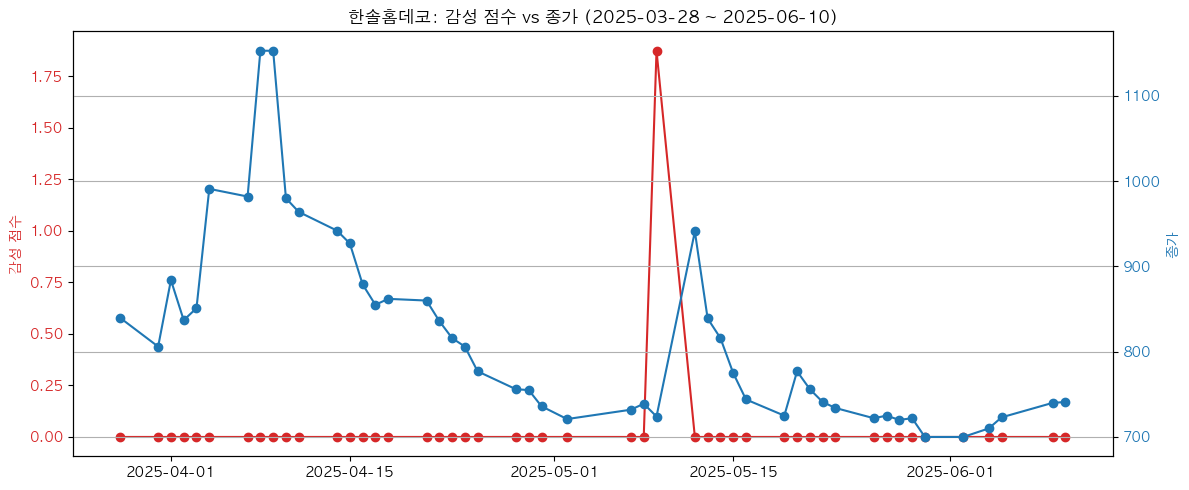

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1247507144.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.      0.      8.8104  2.3649  5.2122 -0.5123]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


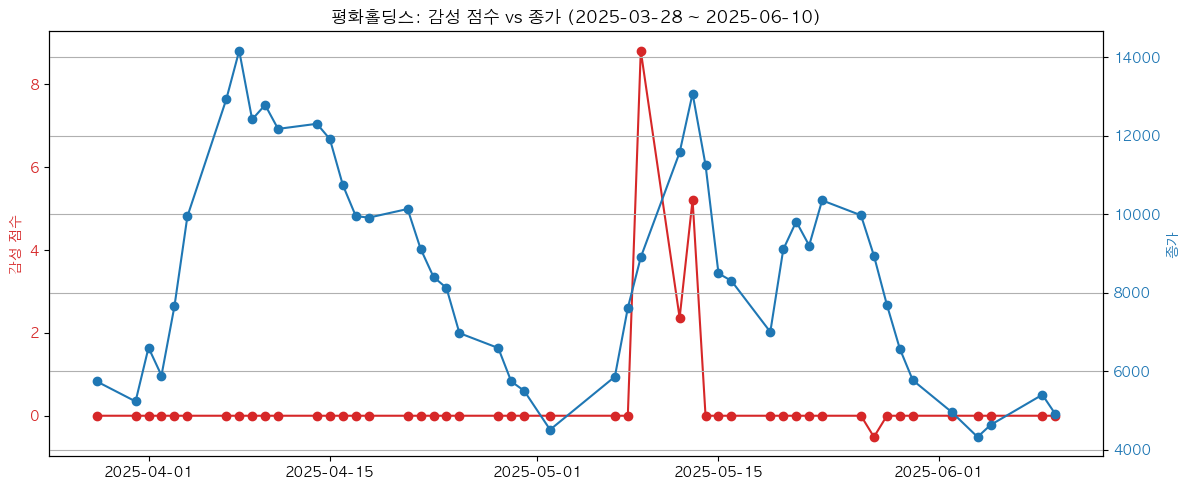

In [ ]:
# ───────────── [3] 감성 점수 + 종가 시각화 ─────────────
for stock_name in all_stock_prices:
    price_df = all_stock_prices[stock_name]
    sentiment_df = all_stock_sentiment.get(stock_name, pd.DataFrame())

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # 감성 점수 시각화 (종가 날짜 기준으로 맞춤)
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) & 
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    base_dates = price_df["Date"]

    # 종가 기준 날짜에 맞춘 감성 점수 매핑 (없으면 0)
    sentiment_series = pd.Series(0, index=base_dates)
    sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])

    # 감성 점수 그래프
    ax1.plot(base_dates, sentiment_series.values, 
             color='tab:red', marker='o', linestyle='-', label="감성 점수")
    ax1.set_ylabel("감성 점수", color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 종가 그래프
    ax2 = ax1.twinx()
    ax2.plot(price_df["Date"], price_df["Close"],
             color='tab:blue', marker='o', linestyle='-', label="종가")
    ax2.set_ylabel("종가", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 제목 및 기타 설정
    plt.title(f"{stock_name}: 감성 점수 vs 종가 (2025-03-28 ~ 2025-06-10)")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

In [ ]:
# 총 기간은 2025-03-28 ~ 2025-06-10
# 팍스넷 데이터가 2025-05-27부터 존재
# 2025-03-28 ~ 2025-05-26까지의 데이터가 비어 있음